In [ ]:
!pip install transformers datasets --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 43.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class FAQDataSet(Dataset):
  def __init__(self, texts, faqs, university_names, tokenizer, max_length = 512):
    self.texts = texts;
    self.faqs = faqs
    self.university_names = university_names
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, id):
    source_text = self.texts[id]
    target_text = self.faqs[id]
    university_name = self.university_names[id]

    source_encodings = self.tokenizer(source_text, max_length = self.max_length, padding = 'max_length', truncation = True, return_tensors = "pt")
    target_encodings = self.tokenizer(target_text, max_length = self.max_length, padding = 'max_length', truncation = True, return_tensors = "pt")

    return {'university_name': university_name,
            'input_ids': source_encodings['input_ids'].squeeze(0),
            'attention_mask': source_encodings['attention_mask'].squeeze(0),
            'labels': target_encodings['input_ids'].squeeze(0)
           }

In [ ]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [ ]:
data = pd.read_csv('/content/data.csv')
data.fillna('No data available', inplace = True)
data['FAQs'] = data['FAQs'].apply(lambda ele: " ".join(ele.split(" | ")))
grouped_data = data.groupby('University Name').agg({'Admission Text': 'first', 'FAQs': ' '.join}).reset_index()

train_data, temp_val_data = train_test_split(grouped_data, test_size = 0.2)
val_data, test_data = train_test_split(temp_val_data, test_size = 0.5)

train_dataset = FAQDataSet(train_data['Admission Text'].tolist(), train_data['FAQs'].tolist(), train_data['University Name'].tolist(), tokenizer)
val_dataset = FAQDataSet(val_data['Admission Text'].tolist(), val_data['FAQs'].tolist(), val_data['University Name'].tolist(), tokenizer)
test_dataset = FAQDataSet(test_data['Admission Text'].tolist(), test_data['FAQs'].tolist(), test_data['University Name'].tolist(), tokenizer)

In [ ]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False, num_workers = 4, pin_memory = True)
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base').to(device)
optimizer = AdamW(model.parameters(), lr = 5e-5)

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 training loss: 8.6193, validation loss: 4.4686
Epoch 2 training loss: 3.2757, validation loss: 2.2969
Epoch 3 training loss: 1.6034, validation loss: 1.0805
Epoch 4 training loss: 0.8118, validation loss: 0.7506
Epoch 5 training loss: 0.5854, validation loss: 0.6856


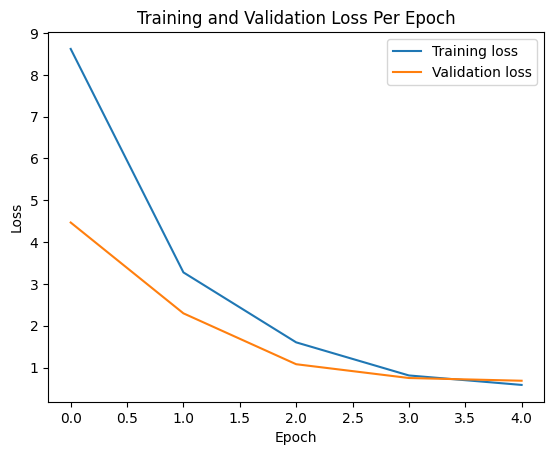

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('./trained_bart_faq_generator/tokenizer_config.json',
 './trained_bart_faq_generator/special_tokens_map.json',
 './trained_bart_faq_generator/vocab.json',
 './trained_bart_faq_generator/merges.txt',
 './trained_bart_faq_generator/added_tokens.json')

In [ ]:
training_losses = []
validation_losses = []

def evaluate_model(model, val_loader, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
            loss = outputs.loss
            val_loss += loss.item()

    return val_loss / len(val_loader)

# Training loop
model.train()
epochs = 5

for epoch in range(epochs):
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = evaluate_model(model, val_loader, device)
    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} training loss: {avg_train_loss:.4f}, validation loss: {avg_val_loss:.4f}")

plt.plot(training_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save_pretrained('./trained_bart_faq_generator')
tokenizer.save_pretrained('./trained_bart_faq_generator')

In [ ]:
def Faq_generation(model, tokenizer, context, max_length = 512):
  model.eval()
  inputs = tokenizer(context, return_tensors = 'pt', max_length = max_length, truncation = True, padding = 'max_length').to(model.device)
  input_ids = inputs['input_ids'].to(model.device)
  attention_mask = inputs['attention_mask'].to(model.device)
  generated_ids = model.generate(input_ids, attention_mask = attention_mask, max_length = max_length, num_beams = 5, no_repeat_ngram_size = 2, early_stopping = True)
  generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens = True)
  return generated_text

In [ ]:
!pip install rouge

In [ ]:
pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [ ]:
from bert_score import BERTScorer
from rouge import Rouge

results = []
model_faqs = []

for _, row in test_data.iterrows():
    context = row['Admission Text']
    generated_faq = Faq_generation(model, tokenizer, context)
    model_faqs.append(generated_faq)
    results.append({'University Name': row['University Name'],
                'Admission Text': row['Admission Text'],
                'Generated FAQ': generated_faq,
                'Actual FAQ': row['FAQs']
                })

results_df = pd.DataFrame(results)
results_df.to_csv('BART_faqs.csv', index = False)
reference_faqs = test_data['FAQs'].tolist()
scorer = BERTScorer(lang = "en", rescale_with_baseline = True)
P, R, F1 = scorer.score(model_faqs, reference_faqs, verbose = True)
print(f"BERTScore- Precision = {P.mean():.3f}, Recall = {R.mean():.3f}, F1 = {F1.mean():.3f}")

rouge = Rouge()
scores = rouge.get_scores(model_faqs, reference_faqs, avg = True)
print("ROUGE-1:", scores['rouge-1']['f'])  # F1-score of ROUGE-1
print("ROUGE-2:", scores['rouge-2']['f'])  # F1-score of ROUGE-2
print("ROUGE-L:", scores['rouge-l']['f'])  # F1-score of ROUGE-L

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.65 seconds, 15.37 sentences/sec
BERTScore- Precision = 0.282, Recall = 0.174, F1 = 0.226
ROUGE-1: 0.29429552464079
ROUGE-2: 0.1296676510921424
ROUGE-L: 0.240102609972691
